In [1]:
import requests

import os
import os.path as pth

from multiprocessing import Pool
from functools import partial

from tqdm.notebook import tqdm

import zipfile

In [2]:
def download_file_from_google_drive(id_, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id_ }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id_, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
        
    basename = response.headers['Content-Disposition'].split(';')[1].split('filename=')[1].replace('\"', '')
    full_dst_filenname = pth.join(destination, basename)
    save_response_content(response, full_dst_filenname)
    return full_dst_filenname

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
file_id_list = [
    '1teoTI59iNyk5zEIpYA6zvzkVfhxSaN5O',
    '1DwENW_2csGmZ74vuKAJKuSGwSw0ONHG9',
    '1S9XCeRbvfO0wNnVXyO3-3AuIm-ukSX6Q',
    '1FCoMm9E5uoE01-YMfndLYoPNnJrapsth',
]

In [4]:
destination = 'data' ### YOUR_DOWNLOAD_PATH
os.makedirs(destination, exist_ok=True)

filename_list = []

# ### Use single process
# for file_id in file_id_list:
#     filename = download_file_from_google_drive(id_=file_id, destination=destination)
#     print('{} is done!'.format(filename))
#     filename_list.append(filename)

### If you want to download more faster
download_func = partial(download_file_from_google_drive, destination=destination)
with Pool(4) as pool:
    for i, filename in tqdm(enumerate(pool.imap_unordered(download_func, file_id_list)), total=len(file_id_list)):
        print('{} is done!'.format(filename))
        filename_list.append(filename)

data/submission.csv is done!
data/train_answer.csv is done!
data/test.zip is done!
data/train.zip is done!



In [5]:
zip_filename_list = [filename for filename in filename_list if filename.endswith('.zip')]
    
for zip_filename in tqdm(zip_filename_list):
    with zipfile.ZipFile(zip_filename) as target_zip:
        dest_path = pth.splitext(zip_filename)[0]
        os.makedirs(dest_path, exist_ok=True)
        target_zip.extractall(dest_path)
        print('{} is done!'.format(dest_path))

data/test is done!
data/train is done!



In [11]:
!pip install torchaudio

     |████████████████████████████████| 3.2MB 2.8MB/s 


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from scipy.io import wavfile
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [17]:
def data_loader(files):
    out = []
    for file in tqdm(files):
        fs, data = wavfile.read(file)
        out.append(data)    
    out = np.array(out)
    return out

In [18]:
# Wav 파일로부터 Feature를 만듭니다.
x_data = glob('data/train/*.wav')
x_data = data_loader(x_data)
x_data = x_data[:, ::8] # 매 8번째 데이터만 사용
x_data = x_data / 30000 # 최대값 30,000 을 나누어 데이터 정규화
x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1) # CNN 모델에 넣기 위한 데이터 shape 변경

# 정답 값을 불러옵니다
y_data = pd.read_csv('data/train_answer.csv', index_col=0)
y_data = y_data.values

# Feature, Label Shape을 확인합니다.
x_data.shape, y_data.shape

100%|██████████| 100000/100000 [00:06<00:00, 14745.10it/s]


((100000, 2000, 1), (100000, 30))

In [19]:
# 모델을 만듭니다.
model = Sequential()
model.add(Conv1D(16, 32, activation='relu', input_shape=(x_data.shape[1], x_data.shape[2])))
model.add(MaxPooling1D())
model.add(Conv1D(16, 32, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 32, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 32, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 32, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='softmax'))
model.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam')

In [20]:
# 모델 폴더를 생성합니다.
model_path = 'model/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# Validation 점수가 가장 좋은 모델만 저장합니다.
model_file_path = model_path + 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델을 학습시킵니다.
history = model.fit(
    x_data, y_data, 
    epochs=100, batch_size=256, validation_split=0.2, shuffle=True,
    callbacks=[checkpoint, early_stopping]
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 28s 344us/step - loss: 2.1233 - val_loss: 2.0893

Epoch 00001: val_loss improved from inf to 2.08926, saving model to model/Epoch_001_Val_2.089.hdf5
Epoch 2/100
80000/80000 [==============================] - 18s 225us/step - loss: 2.0878 - val_loss: 2.0889

Epoch 00002: val_loss improved from 2.08926 to 2.08893, saving model to model/Epoch_002_Val_2.089.hdf5
Epoch 3/100
80000/80000 [==============================] - 18s 226us/step - loss: 2.0848 - val_loss: 2.0887

Epoch 00003: val_loss improved from 2.08893 to 2.08873, saving model to model/Epoch_003_Val_2.089.hdf5
Epoch 4/100
80000/80000 [==============================] - 19s 241us/step - loss: 2.0835 - val_loss: 2.0903

Epoch 00004: val_loss did not improve from 2.08873
Epoch 5/100
80000/80000 [==============================] - 18s 229us/step - loss: 2.0832 - val_loss: 2.0891

Epoch 00005: val_loss did not improve from 2.0887

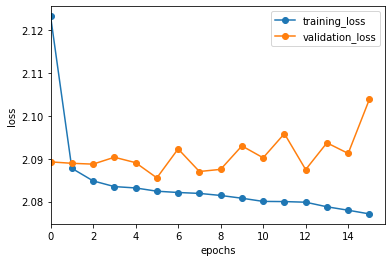

In [21]:
# 훈련 결과를 확인합니다.
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
# 검증 wav 파일로부터 Feature를 만듭니다.
x_test = glob('data/test/*.wav')
x_test = data_loader(x_test)
x_test = x_test / 30000
x_test = x_test[:, ::8]
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('model/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('submission.csv')

100%|██████████| 10000/10000 [00:11<00:00, 901.03it/s]


model/Epoch_002_Val_2.089.hdf5
